# MiniRun6 LRS tutorial 3

In [32]:
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm
from matplotlib import colors, ticker
import itertools

!pip install ./h5flow
from h5flow.data import dereference
from proto_nd_flow.util.lut import LUT

Processing ./h5flow
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31716 sha256=bf06c801742031e8406bea50475a19135e5c7d935a37357304fd691d02e0a187
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ffzipg4/wheels/f1/5d/58/77983378fc64f41b62b695d5a44d952fa4c38d69af5c3ba1f2
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


In [33]:
# load csv generated in lrs_sanity_check from yaml file proto_nd_flow
channel_status = pd.read_csv('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_status/channel_status.csv', header=None).to_numpy()
print('Channel Status Shape:', np.shape(channel_status))

# load calibration csv as df
path = '/global/homes/j/jvmead/dune/lrs_sanity_check/calibration/data_calib.csv'
calib = pd.read_csv(path, header=None).to_numpy()
print(calib.shape)


fname = '/global/cfs/cdirs/dune/www/data/2x2/reflows/v11/flow/beam/july10_2024/nominal_hv/packet-0050018-2024_07_10_12_56_35_CDT.FLOW.hdf5'
f = h5py.File(fname)

Channel Status Shape: (8, 64)
(8, 64)


In [34]:
max_events = 100
events = np.linspace(0,max_events,max_events+1,dtype=int)

light_wvfms = f['light/wvfm/data/']['samples'][events]/4.0
print(light_wvfms.shape)

sipm_hits = f['light/sipm_hits/data']
print(sipm_hits.dtype.names)
print(sipm_hits.shape)

(101, 8, 64, 1000)
('id', 'adc', 'chan', 'pos', 'sample_idx', 'ns', 'busy_ns', 'samples', 'sum', 'max', 'sum_spline', 'max_spline', 'ns_spline', 'rising_spline', 'rising_err_spline', 'fwhm_spline')
(112327,)


In [35]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light.assertwvfm_noise_filter
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/wvfm_noise_filter.py#L97-L123
def min_range_baseline(array, segment_size=25, num_segments=40, num_means=4):

    # Define start and end indices for segments
    indices = np.arange(num_segments + 1) * segment_size  # (41,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (40,)

    # Generate index array for advanced indexing
    segment_range = np.arange(segment_size)  # (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (40, 25)

    # Extract data from segments using indexing
    sliced_data = array[..., index_array]  # Shape (..., 40, 25)

    # Compute range (peak-to-peak difference) and mean for each segment
    ranges = np.abs(np.ptp(sliced_data, axis=-1))  # Shape (..., 40)
    means = np.mean(sliced_data, axis=-1)  # Shape (..., 40)

    # Mask zero ranges
    mask_zero = (ranges != 0)
    ranges = np.where(mask_zero, ranges, np.nan)
    means = np.where(mask_zero, means, np.nan)

    # Find the ordering of the segments based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (..., 40)

    # Sort means according to the ordering of smallest ranges
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (..., 40)

    # Compute the average of the 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:num_means], axis=-1)  # Shape (...)

    # calculate RMS for the ranges of the smallest range segments
    rms = np.sqrt(np.mean(np.square(np.take_along_axis(ranges, smallest_ordering[..., :num_means], axis=-1)), axis=-1))

    return average_mean, rms

baselines, rms = min_range_baseline(light_wvfms)
print(baselines.shape)
print(rms.shape)

(101, 8, 64)
(101, 8, 64)


In [36]:
light_wvfms_baselined = light_wvfms - baselines[:, :, :, np.newaxis]
print(light_wvfms_baselined.shape)
cwvfms = light_wvfms_baselined * calib[np.newaxis, :, :, np.newaxis]
rms_calib = rms * calib[np.newaxis, :, :]

(101, 8, 64, 1000)


In [37]:
# a function to get the 6 channels on the same EPCB
def get_epcb_channels(channel):
    if channel < 0 or channel > 63:
        return []  # invalid
    epcb = channel // 6
    return [(epcb * 6 + i) for i in range(6)]

# a function which takes the ADC and channel and gives a TPC number
def adc_channel_to_tpc(adc, channel):

    # use channels to determine if channel is in odd or even TPC
    if channel < 0 or channel > 63:
        return -1  # invalid
    if adc < 0 or adc > 7:
        return -1  # invalid
    tpc = adc + (channel // 32)
    tpc -= 1 if (adc % 2) else 0
    return tpc

# a function which takes a TPC number and gives a list of (adc, channel) tuples
def tpc_to_adc_channel(tpc):
    if tpc < 0 or tpc > 7:
        return []  # invalid
    channel_start = (tpc % 2) * 32
    channel_list = range(channel_start, channel_start + 32)
    channel_list = [ch for ch in channel_list if channel_status[tpc, ch] >= 0]

    adc_list = [tpc]
    if tpc % 2 == 0:
        adc_list.append(tpc + 1)
    else:
        adc_list.append(tpc - 1)

    adc_channel_list = [(adc, ch) for adc in adc_list for ch in channel_list]
    return adc_channel_list

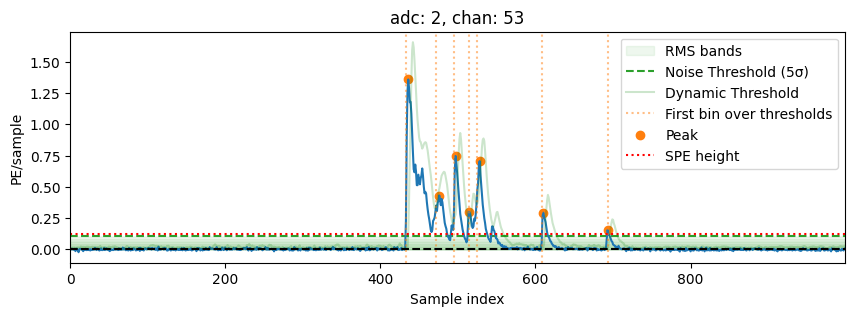

In [38]:
from scipy.ndimage import uniform_filter1d

def plot_waveform_with_hit_finder(wvfm, noise, adc, chan,
                                  n_noise_factor,
                                  n_bins_rolled,
                                  n_sqrt_rt_factor,
                                  pe_weight=0.12):

    # height = flat threshold over noise (n*sigma)
    height = n_noise_factor * noise[..., np.newaxis] * np.ones(wvfm.shape[-1])

    # dynamic_threshold = rolling threshold of previous 5 bins + n*sqrt(rolling threshold)
    wvfm_rolled = np.roll(wvfm, n_bins_rolled)
    rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
    sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
    sqrt_rolling_average[sqrt_rolling_average == 0] = 1
    dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average

    # find bins over dynamic threshold and noise floor
    bins_over_dynamic_threshold = (wvfm > dynamic_threshold) & (wvfm > height)

    # Find first bins over threshold (rising edge)
    first_bins_over = bins_over_dynamic_threshold.copy()
    first_bins_over[..., 1:] &= ~bins_over_dynamic_threshold[..., :-1]

    # check 5 bins after first_bins_over and add argmax
    peak_bins = np.zeros_like(wvfm, dtype=bool)
    first_bins_indices = np.where(first_bins_over)
    for idx in zip(*first_bins_indices):
        start_idx = idx[-1]
        end_idx = min(start_idx + 5, wvfm.shape[-1])
        peak_bin = np.argmax(wvfm[idx[:-1] + (slice(start_idx, end_idx),)])
        peak_bins[idx[:-1] + (start_idx + peak_bin,)] = True
    hits = np.where(peak_bins)[-1] if np.any(peak_bins) else np.array([])

    plt.figure(figsize=(10, 3))
    n_rms = 5
    for k in range(1, n_noise_factor + 1):
        plt.fill_between(
            np.arange(len(wvfm)),
            0 * noise,
            k * noise,
            color='tab:green', alpha=0.08, label=f'RMS bands' if k == 1 else None
        )
    plt.axhline(n_rms * noise, color='tab:green', label=f'Noise Threshold ({n_rms}σ)', linestyle='--')
    plt.plot(wvfm)
    plt.plot(dynamic_threshold, label='Dynamic Threshold', color='green', alpha=0.2)
    # for each hit in hits, plot a orange dot
    if np.any(hits):
        for i, bin in enumerate(first_bins_indices[0]):
            label = f'First bin over thresholds' if i == 0 else None
            plt.axvline(bin, color='tab:orange', linestyle=':',
                        alpha=0.5, label=label)
        plt.scatter(hits, wvfm[hits], label='Peak', c='tab:orange')
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(pe_weight, color='r', linestyle=':', label='SPE height')
    plt.xlabel('Sample index')
    plt.ylabel('PE/sample')
    plt.legend()
    plt.xlim(0, len(wvfm)-1)
    plt.title(f'adc: {adc}, chan: {chan}')
    plt.show()

# example usage
evt = 3
adc = 2
chan = 53
plot_waveform_with_hit_finder(wvfm=cwvfms[evt, adc, chan],
                              noise=rms_calib[evt, adc, chan],
                              adc=adc,
                              chan=chan,
                              n_noise_factor=5,
                              n_bins_rolled=5,
                              n_sqrt_rt_factor=3,
                              pe_weight=0.12)

In [39]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light.assertwvfm_noise_filter
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/hit_finder.py#L189-L231

def peak_finder(#self,
                wvfm, noise,
                n_noise_factor = 5,
                n_bins_rolled = 5,
                n_sqrt_rt_factor = 3,
                pe_weight = 0.12,
                use_rising_edge=False,
                use_local_maxima=True):

    # height = flat threshold over noise (n*sigma)
    height = n_noise_factor * noise[..., np.newaxis] * np.ones(wvfm.shape[-1])
    # dynamic_threshold = rolling threshold of previous 5 bins + n*sqrt(rolling threshold)
    wvfm_rolled = np.roll(wvfm, n_bins_rolled)
    rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
    sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
    sqrt_rolling_average[sqrt_rolling_average == 0] = 1
    dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
    # find bins over dynamic threshold and noise floor
    bins_over_dynamic_threshold = (wvfm > dynamic_threshold) & (wvfm > height)
    # Find first bins over threshold (rising edge)
    first_bins_over = bins_over_dynamic_threshold.copy()
    first_bins_over[..., 1:] &= ~bins_over_dynamic_threshold[..., :-1]
    if use_rising_edge:
        return first_bins_over
    # Peak finding
    elif use_local_maxima:
        # check 5 bins after first_bins_over and add argmax
        peak_bins = np.zeros_like(wvfm, dtype=bool)
        first_bins_indices = np.where(first_bins_over)
        for idx in zip(*first_bins_indices):
            start_idx = idx[-1]
            end_idx = min(start_idx + 5, wvfm.shape[-1])
            peak_bin = np.argmax(wvfm[idx[:-1] + (slice(start_idx, end_idx),)])
            peak_bins[idx[:-1] + (start_idx + peak_bin,)] = True
    else:
        # Derivative-based peak detection
        wvfm_d1 = np.gradient(wvfm, axis=-1)
        wvfm_d2 = np.gradient(wvfm_d1, axis=-1)
        peak_bins = (wvfm > dynamic_threshold) & (wvfm > height) & \
            (wvfm_d1 < 0) & (wvfm_d2 < 0)
        # Keep only the first peak in consecutive runs
        peak_bins[..., 1:] &= ~peak_bins[..., :-1]

    return peak_bins


# generate hits from waveforms using peak_finder
sipm_hits = peak_finder(wvfm=cwvfms, noise=rms_calib)

print('SIPM Hits Shape:', sipm_hits.shape)  # (events, 8, 64, samples)

SIPM Hits Shape: (101, 8, 64, 1000)


In [50]:
def plot_waveform_with_hits(waveform, hits, evt, adc, chan):
    plt.figure(figsize=(10, 3))
    plt.plot(waveform)
    # for each hit in hits, plot a orange dot
    if np.any(hits):
        hit_idx = np.where(hits)[0]
        plt.scatter(hit_idx, waveform[hit_idx], label='hit', c='tab:orange')
    plt.xlabel('Sample index')
    plt.ylabel('PE/sample')
    plt.legend()
    plt.xlim(0, len(waveform)-1)
    plt.title(f'evt: {evt}, adc: {adc}, chan: {chan}')
    plt.show()

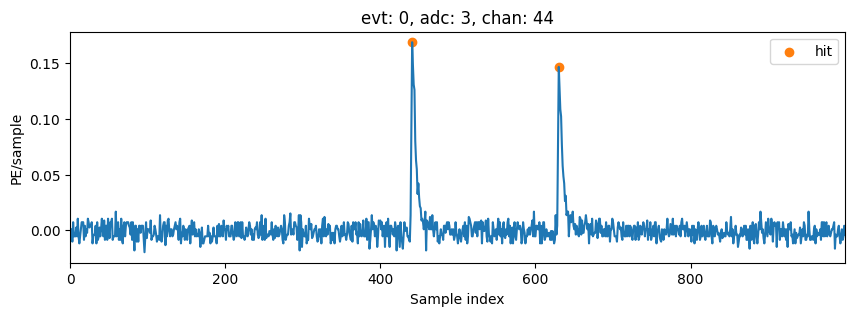

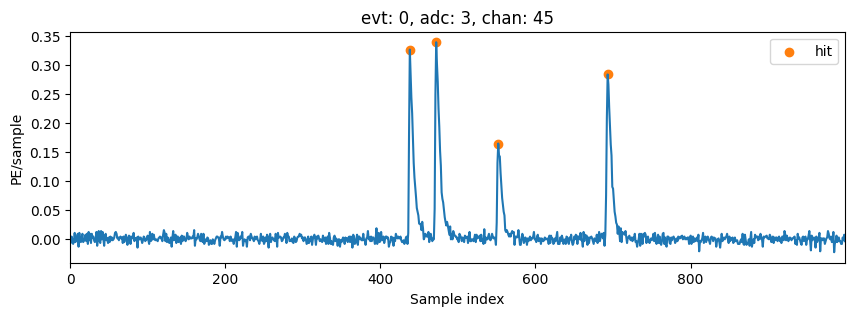

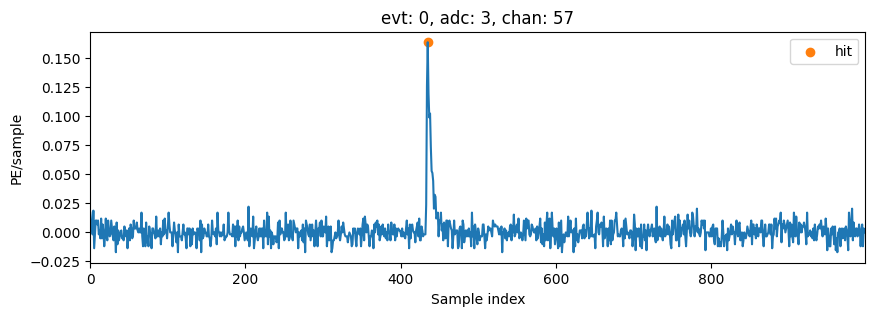

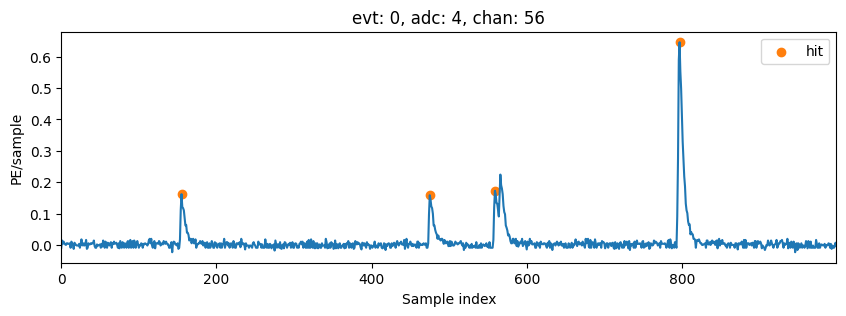

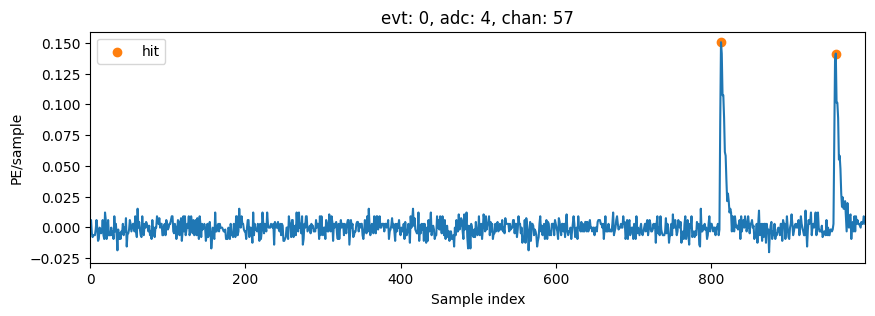

In [63]:
def plot_waveforms_with_hits(light_wvfms, hits, channel_status, exclude_mod0=False,
                             event_ids=None, adc_list=None, channel_list=None,
                             max_nplots=None, require_hits=True):
    n_plots = 0

    if event_ids is None:
        event_ids = range(light_wvfms.shape[0])

    for evt in event_ids:
        samples_event = light_wvfms[evt]  # shape: (8, 64, 1000)
        hits_event = hits[evt]            # shape: (8, 64, N)
        rms_event = rms[evt]              # shape: (8, 64)
        found_hit = False
        if adc_list is None:
            adc_range = range(2, 8) if exclude_mod0 else range(8)
        else:
            adc_range = adc_list
        for adc in adc_range:
            if channel_list is None:
                channel_range = range(samples_event.shape[1])
            else:
                channel_range = channel_list
            for chan in channel_range:
                # Only plot if there are hits in this channel
                if require_hits and not np.any(hits_event[adc, chan, :]):
                    #print(f"No hits found for event {evt}")
                    continue
                if channel_status[adc, chan] == 0:
                    if max_nplots is not None and n_plots >= max_nplots:
                        return
                    plot_waveform_with_hits(samples_event[adc, chan, :],
                                            hits_event[adc, chan, :],
                                            evt, adc, chan)
                    n_plots += 1

# Example usage:
plot_waveforms_with_hits(cwvfms, sipm_hits, channel_status, event_ids=None,
                         exclude_mod0=False, require_hits=True, max_nplots=5)

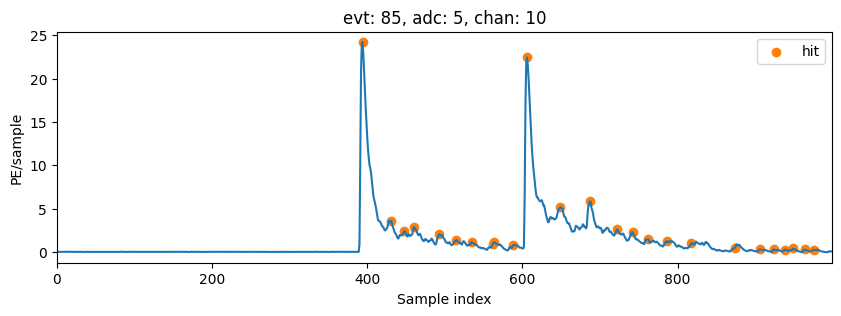

In [60]:
# Example: Better SNR waveform
evt = 85  # example event
adc = 5  # example ADC number
chan = [10,11,12,13,14,15]  # example channel number

plot_waveforms_with_hits(cwvfms, sipm_hits, channel_status, exclude_mod0=False,
                         event_ids=[evt], adc_list=[adc], channel_list=chan,
                         max_nplots=1, require_hits=False)

In [67]:
def plot_tpc_waveforms_with_hits(light_wvfms, sipm_hits, event_id, tpc_number, channel_status=None):
  samples = light_wvfms[event_id]  # shape: (8, 64, 1000)
  hits = sipm_hits[event_id]       # shape: (8, 64, 1000)
  if tpc_number < 0 or tpc_number > 8:
    print("Invalid TPC number. Must be 0-8.")
    return

  adc_channel_list = tpc_to_adc_channel(tpc_number)
  if not adc_channel_list:
    print(f"No valid ADC and channel pairs found for TPC {tpc_number}.")
    return

  adc_list = sorted(set(adc for adc, ch in adc_channel_list), reverse=True)
  channel_list = sorted(set(ch for adc, ch in adc_channel_list), reverse=True)

  fig, axs = plt.subplots(4, 2, figsize=(10, 9), sharex=True, sharey=True)
  for v_idx in range(4):
    for h_idx in range(2):
      ax = axs[v_idx, h_idx]
      adc = adc_list[v_idx % 2]
      channels = channel_list[h_idx * 12 + (v_idx // 2) * 6 : h_idx * 12 + (v_idx // 2) * 6 + 6]
      for ch in channels:
        if channel_status is not None and channel_status[adc, ch] != 0:
          continue
        ax.plot(samples[adc, ch, :], alpha=0.5, label=f'[{adc},{ch}]')
        hit_idx = np.where(hits[adc, ch, :])[0]
        if hit_idx.size > 0:
          for idx in hit_idx:
              ax.axvline(idx, color='red', linestyle='--', linewidth=0.25)
      # empty entry for legend formatting
      ax.axvline(-1, color='red', linestyle='--', label='hits', linewidth=0.1)
      ax.set_xlabel('Sample index')
      ax.set_ylabel('PE/sample')
      ax.set_xlim(0, samples.shape[2] - 1)
      ax.legend(fontsize='small', bbox_to_anchor=(1.01, 1), loc='upper left')
  plt.suptitle(f'Event {event_id}, TPC {tpc_number}')
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

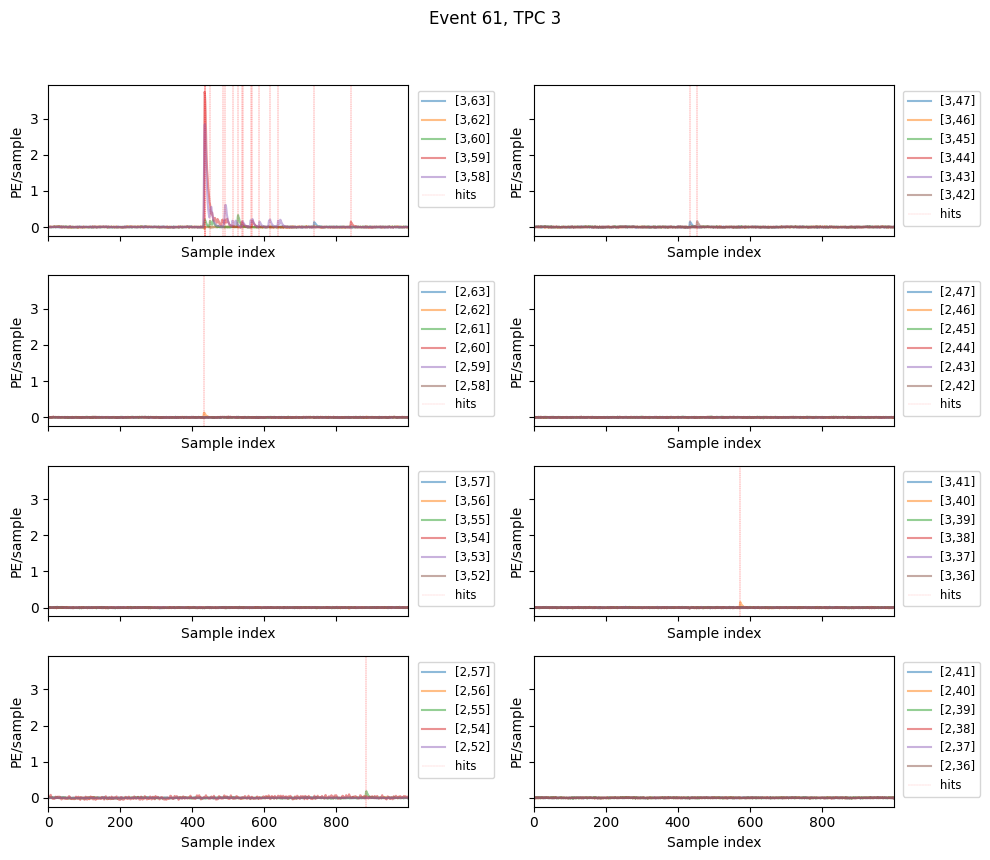

In [68]:
plot_tpc_waveforms_with_hits(cwvfms, sipm_hits, 61, 3, channel_status=channel_status)

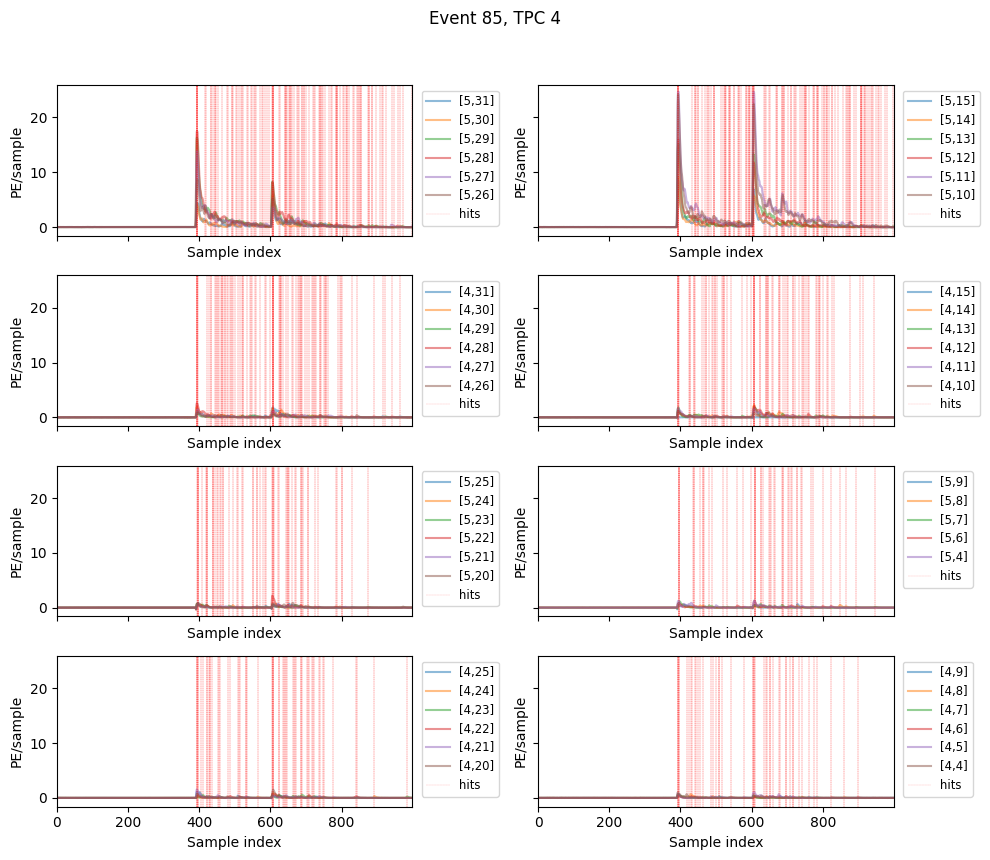

In [69]:
plot_tpc_waveforms_with_hits(cwvfms, sipm_hits, 85, 4, channel_status=channel_status)

In [71]:
def plot_tpc_waveforms_with_hits_hist(light_wvfms, sipm_hits, event_id, tpc_number,
                                 channel_status=None, weight_by_height=False):
  samples = light_wvfms[event_id]  # shape: (8, 64, 1000)
  hits = sipm_hits[event_id]       # shape: (8, 64, 1000)
  if tpc_number < 0 or tpc_number > 8:
    print("Invalid TPC number. Must be 0-8.")
    return

  adc_channel_list = tpc_to_adc_channel(tpc_number)
  if not adc_channel_list:
    print(f"No valid ADC and channel pairs found for TPC {tpc_number}.")
    return

  adc_list = sorted(set(adc for adc, ch in adc_channel_list), reverse=True)
  channel_list = sorted(set(ch for adc, ch in adc_channel_list), reverse=True)

  # get max wvfm value for y limit
  wvfm_max = np.nanmax(samples[np.ix_(adc_list, channel_list, range(samples.shape[2]))])

  fig, axs = plt.subplots(8, 2, figsize=(10, 14), sharex=True, #sharey=True,
                          gridspec_kw={'height_ratios': [2 if i % 2 == 0 else 1 for i in range(8)]})
  for v_idx in range(8):
    for h_idx in range(2):
      ax = axs[v_idx, h_idx]

      # dumb logic to get the right adc and channels for each subplot
      adc = adc_list[(v_idx // 2) % 2]
      base = h_idx * 12
      offset = (v_idx // 4) * 6   # maps 0..7 → 0,0,1,1,2,2,2,2
      channels = channel_list[base + offset : base + offset + 6]

      # plot waveforms with hits overlaid
      if v_idx % 2 == 0:
        ax.set_ylim(-0.05*wvfm_max, 1.2*wvfm_max)

        for ch in channels:
          if channel_status is not None and channel_status[adc, ch] != 0:
            continue
          ax.plot(samples[adc, ch, :], alpha=0.5, label=f'[{adc},{ch}]')
          hit_idx = np.where(hits[adc, ch, :])[0]
          if hit_idx.size > 0:
            for idx in hit_idx:
                ax.axvline(idx, color='red', linestyle='--', linewidth=0.25)
        # empty entry for legend formatting
        ax.axvline(-1, color='red', linestyle='--', label='hits', linewidth=0.1)
        ax.set_xlabel('Sample index')
        ax.set_ylabel('PE/sample')
        ax.set_xlim(0, samples.shape[2] - 1)
        ax.legend(fontsize='small', bbox_to_anchor=(1.01, 1), loc='upper left')

      # otherwise make stacked histogram of the hits
      else:
        hit_indices_list = []
        hit_height_list = []
        for ch in channels:
          if channel_status is not None and channel_status[adc, ch] != 0:
            continue
          # Collect hit indices for all 6 channels in this subplot
          for ch in channels:
            if channel_status is not None and channel_status[adc, ch] != 0:
              continue
            hit_idx = np.where(hits[adc, ch, :])[0]
            if hit_idx.size > 0:
              hit_indices_list.append(hit_idx)
              hit_height_list.append(samples[adc, ch, hit_idx])
        # Plot stacked histogram if any hits found
        if hit_indices_list:
          nbins = 100
          bins = np.linspace(0, samples.shape[2], nbins + 1)
          ax.hist(hit_indices_list, bins=bins, stacked=True,
                  alpha=0.5, weights=hit_height_list if weight_by_height else None)

        ax.set_xlabel('Sample index')
        ax.set_ylabel('Hit count')
        ax.set_xlim(0, samples.shape[2] - 1)

  plt.suptitle(f'Event {event_id}, TPC {tpc_number}')
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

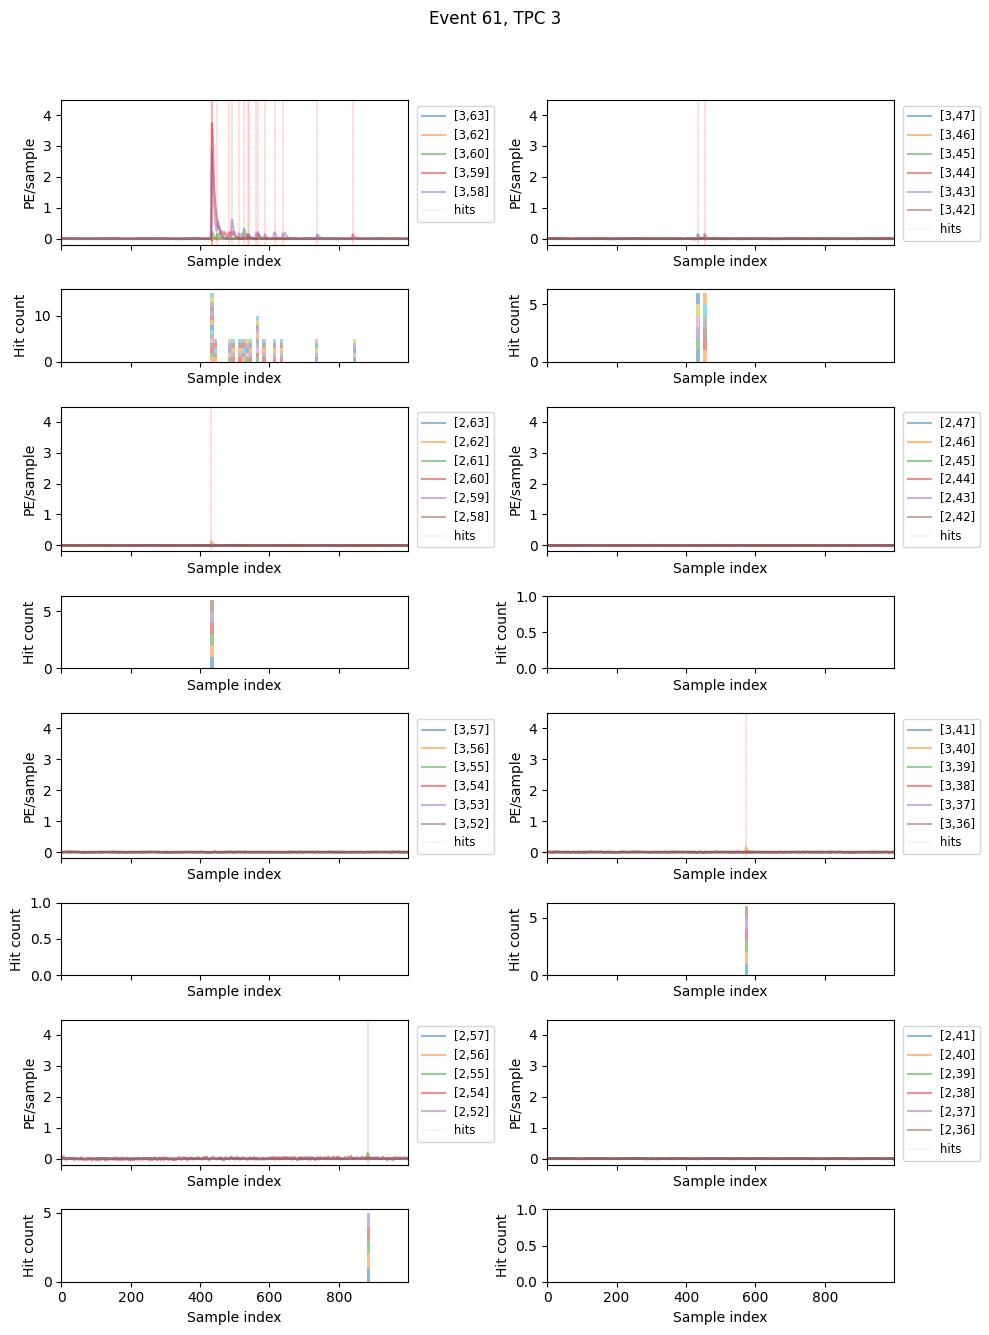

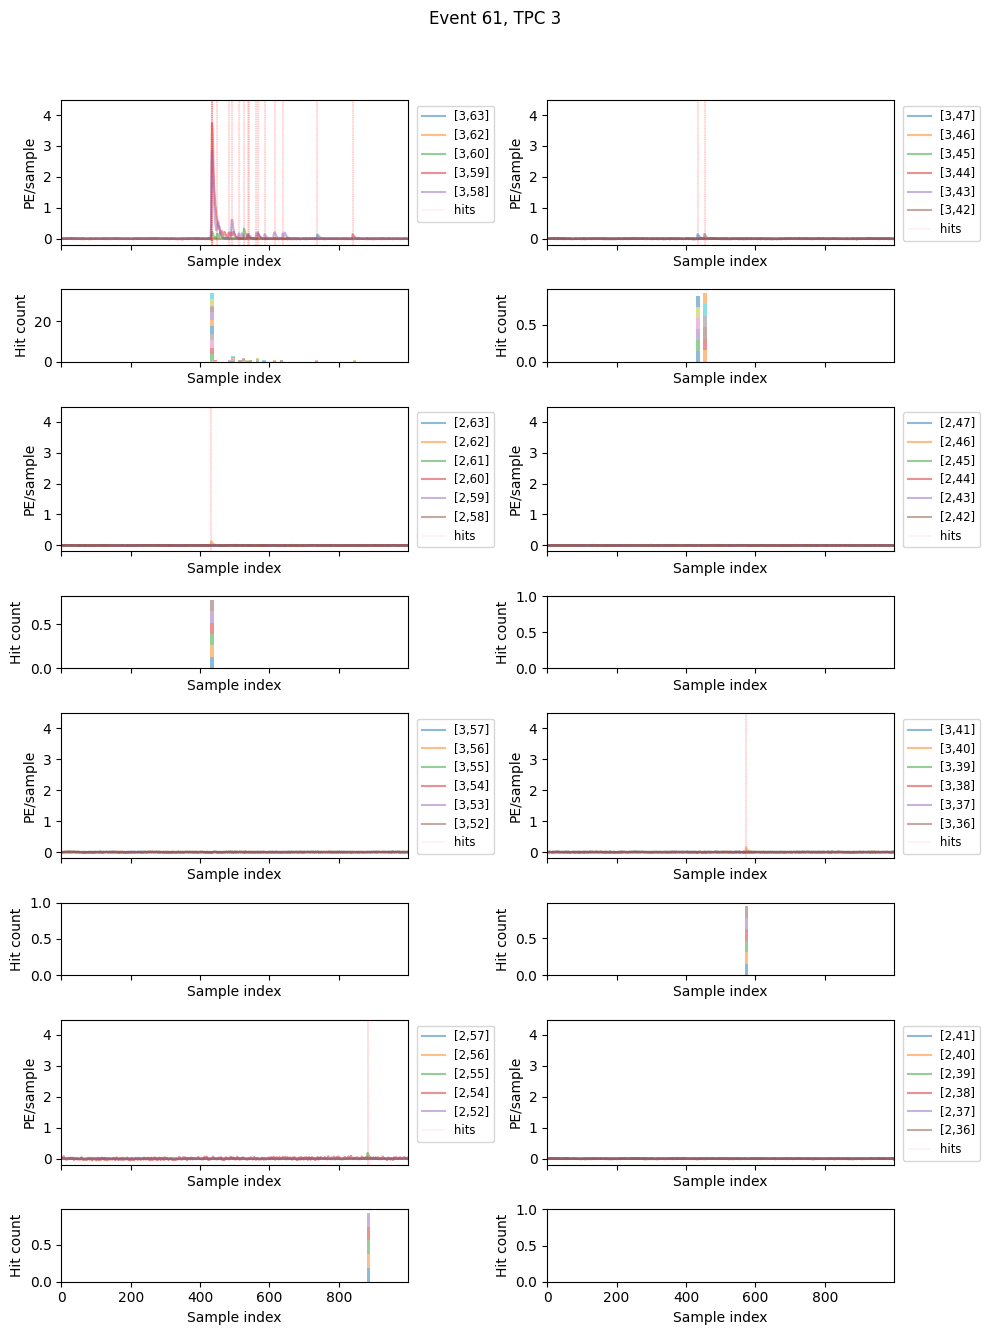

In [72]:
# hists without weight by height
plot_tpc_waveforms_with_hits_hist(cwvfms, sipm_hits, 61, 3,
                                  channel_status=channel_status,
                                  weight_by_height=False)

# with weight by height
plot_tpc_waveforms_with_hits_hist(cwvfms, sipm_hits, 61, 3,
                                  channel_status=channel_status,
                                  weight_by_height=True)

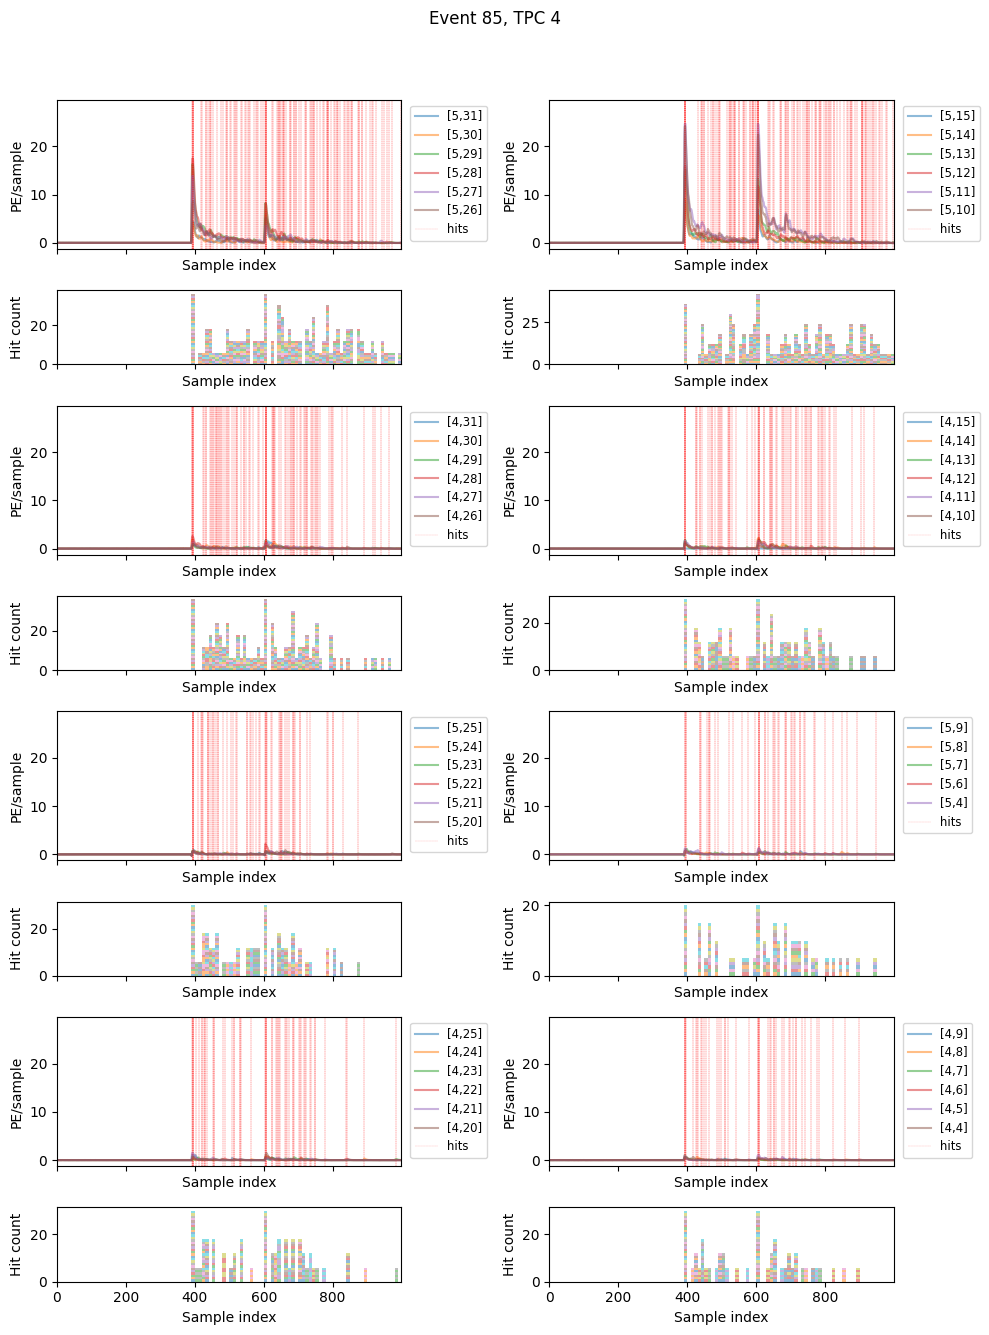

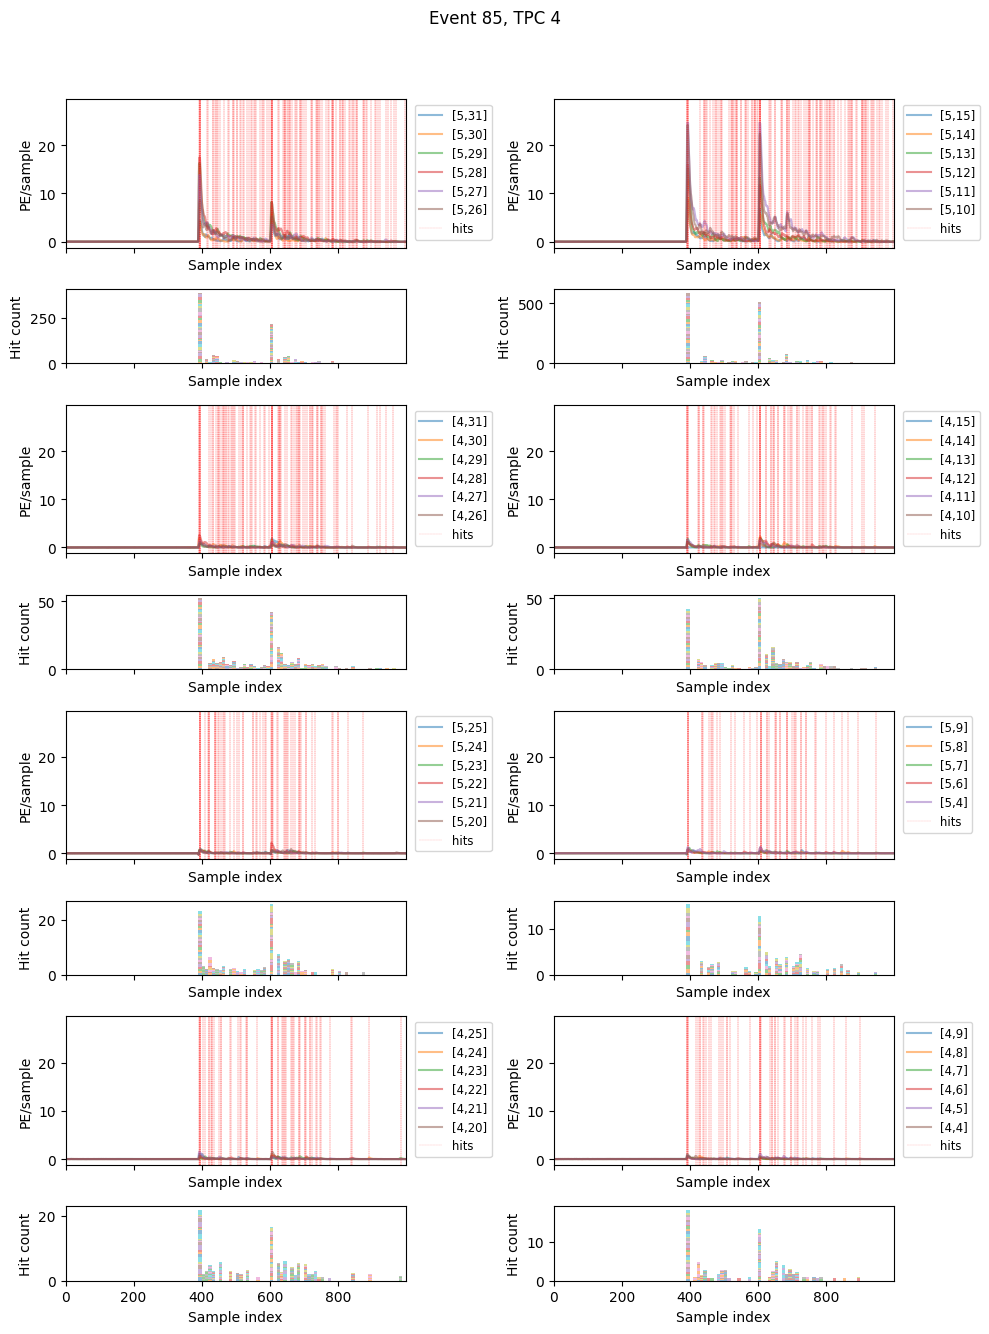

In [74]:
# hists without weight by height
plot_tpc_waveforms_with_hits_hist(cwvfms, sipm_hits, 85, 4,
                                  channel_status=channel_status,
                                  weight_by_height=False)

# with weight by height
plot_tpc_waveforms_with_hits_hist(cwvfms, sipm_hits, 85, 4,
                                  channel_status=channel_status,
                                  weight_by_height=True)